In [1]:
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import faiss

Loading faiss.


In [3]:
infile = 'vecs/tess_ode.pkl'

In [4]:
data = pd.read_pickle(infile)

In [5]:
vecs = np.stack(list(data.values()))

In [6]:
vecs = vecs/np.linalg.norm(vecs, axis=1).reshape(-1,1)

In [7]:
i2f = dict(enumerate(list(data.keys())))

In [8]:
i2f

{0: 'tess2019253231442-s0016-0000000315335924-0152-s_lc',
 1: 'tess2019253231442-s0016-0000000199607786-0152-s_lc',
 2: 'tess2019279210107-s0017-0000000236785664-0161-s_lc',
 3: 'tess2019279210107-s0017-0000000366642024-0161-s_lc',
 4: 'tess2019253231442-s0016-0000000237292421-0152-s_lc',
 5: 'tess2019279210107-s0017-0000000378148491-0161-s_lc',
 6: 'tess2019279210107-s0017-0000000230052083-0161-s_lc',
 7: 'tess2019279210107-s0017-0000000236761213-0161-s_lc',
 8: 'tess2019279210107-s0017-0000000229780215-0161-s_lc',
 9: 'tess2019253231442-s0016-0000000359584313-0152-s_lc',
 10: 'tess2019279210107-s0017-0000000264077667-0161-s_lc',
 11: 'tess2019253231442-s0016-0000000286946484-0152-s_lc',
 12: 'tess2019253231442-s0016-0000000229612184-0152-s_lc',
 13: 'tess2019253231442-s0016-0000000259006251-0152-s_lc',
 14: 'tess2019279210107-s0017-0000000202796740-0161-s_lc',
 15: 'tess2019253231442-s0016-0000000279981212-0152-s_lc',
 16: 'tess2019253231442-s0016-0000000199682253-0152-s_lc',
 17: 't

### Build DB

In [9]:
d = vecs.shape[1]; d

40

In [10]:
db = faiss.IndexFlatIP(d)

In [11]:
db.add(vecs)

In [12]:
db.ntotal

39991

### Input vec

In [13]:
indir = 'tess/16_17/z_normalized/'
filenames = [indir+x+'.npy' for x in list(data.keys())]

In [14]:
tsne_res = pd.read_pickle('tess_tsne.pkl')

In [15]:
df = pd.DataFrame(zip(filenames, tsne_res[:,0], tsne_res[:,1]),
                      columns = ['file','x1', 'x2'])

In [16]:
plot_bounds = (5,7, 18, 20)

In [17]:
s = df.loc[(df['x1'] > plot_bounds[0]) & (df['x1'] < plot_bounds[1])
       & (df['x2'] > plot_bounds[2]) & (df['x2'] < plot_bounds[3]) ]

In [18]:
def plot_one(sample):
    file = sample['file'].values[0]
    ts = np.load(file)[1]
    plt.figure(figsize=(5,5))
    #     ax.set_title('cluster: ' + str(ixs[i]) + '  ' + 'score: ' + str(probs[i]))
    ax=sns.lineplot(x=np.arange(len(ts)), y=ts, color='k', alpha=0.8)
    ax.set(yticks=[], xticks=[])
    obj_id = file2id(file)
    fname = file.split(indir)[-1][:-4]
    return ax, ts, obj_id, fname

In [19]:
def file2id(file):
    return file.split(indir)[-1].split('-')[2]

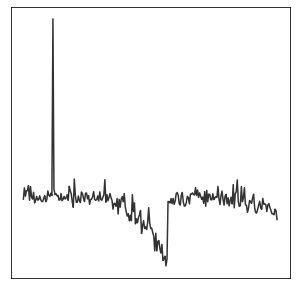

In [20]:
ax, ts, obj_id, fname = plot_one(s.sample(n=1))
input_vec = data[fname]

In [21]:
input_vec

array([-0.13750906, -0.06041998,  0.06820385, -0.07810038,  0.2030462 ,
       -0.13201146, -0.21247199,  0.23700435,  0.07771923, -0.07880722,
       -0.0057422 , -0.22259074, -0.01782268,  0.15964648, -0.11500556,
        0.00545033,  0.05621724, -0.01856674, -0.13345224, -0.02742375,
       -0.10830544,  0.06275364, -0.16978629,  0.04497834,  0.04503253,
        0.13062954, -0.07527729,  0.05239384,  0.20432612,  0.12225027,
       -0.23355605,  0.12283023,  0.06849992,  0.06350884,  0.03907927,
        0.18724488,  0.18355583, -0.02105776, -0.03577131, -0.0943416 ],
      dtype=float32)

In [22]:
fname

'tess2019279210107-s0017-0000000233540482-0161-s_lc'

In [23]:
np.linalg.norm(input_vec)

0.77860165

In [24]:
input_vec = input_vec/np.linalg.norm(input_vec)
input_vec = input_vec.reshape(1,-1)

In [35]:
%timeit db.search(input_vec, k=5)

762 µs ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
probs, ixs = db.search(input_vec, k=6)
ixs = ixs[0]
probs = probs[0]

In [31]:
dict(zip([i2f[i] for i in ixs], probs))

{'tess2019279210107-s0017-0000000233540482-0161-s_lc': 0.9999999,
 'tess2019279210107-s0017-0000000436547082-0161-s_lc': 0.99987936,
 'tess2019279210107-s0017-0000000365544203-0161-s_lc': 0.99986255,
 'tess2019279210107-s0017-0000000229949018-0161-s_lc': 0.99981165,
 'tess2019279210107-s0017-0000000198386011-0161-s_lc': 0.9996409,
 'tess2019279210107-s0017-0000000270921975-0161-s_lc': 0.9996369}

### Quick sample

In [183]:
def roulette(sample):
    file = sample['file'].values[0]
    ts = np.load(file)[1]
#     plt.figure(figsize=(5,5))
#     #     ax.set_title('cluster: ' + str(ixs[i]) + '  ' + 'score: ' + str(probs[i]))
#     ax=sns.lineplot(x=np.arange(len(ts)), y=ts, color='k', alpha=0.8)
#     ax.set(yticks=[], xticks=[])
    obj_id = file2id(file)
    fname = file.split(indir)[-1][:-4]
    input_vec = data[fname]
    input_vec = input_vec/np.linalg.norm(input_vec)
    input_vec = input_vec.reshape(1,-1)
    probs, ixs = db.search(input_vec, k=4)
    ixs = ixs[0]
    files = [indir+i2f[i]+'.npy' for i in ixs.reshape(-1)]
    curves = [np.load(f)[1] for f in files]
    obj_ids = [file2id(f) for f in files]
    return obj_ids, curves

In [158]:
plot_bounds = (-100,100, -100,100)

In [159]:
s = df.loc[(df['x1'] > plot_bounds[0]) & (df['x1'] < plot_bounds[1])
       & (df['x2'] > plot_bounds[2]) & (df['x2'] < plot_bounds[3]) ]

0000000284430205


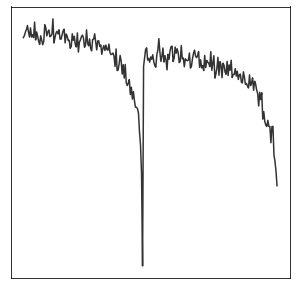

In [172]:
res = roulette(s.sample(n=1))

In [177]:
obj_ids, ys = res
def make_plot():
    f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    for i in range(len(ys)):
        ax = axes[i]
        ax.set_xticks(ticks=[])
        ax.set_yticks(ticks=[])
        ax.set_title('id: ' + str(obj_ids[i]))
        if i == 0:
            sns.lineplot(x=np.arange(len(ys[i])), y=ys[i], color='r', alpha=0.6, ax=ax)
        else:
            sns.lineplot(x=np.arange(len(ys[i])), y=ys[i], color='k', alpha=0.8, ax=ax)
    return f

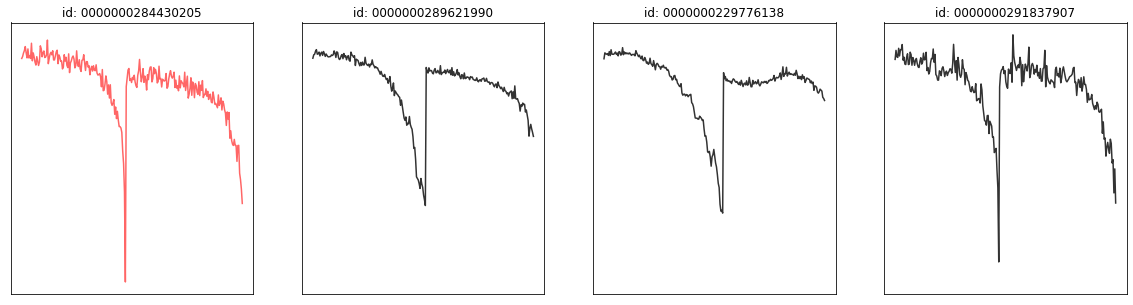

In [179]:
f

In [181]:
obj_ids

['0000000284430205',
 '0000000289621990',
 '0000000229776138',
 '0000000291837907']

In [180]:
f.savefig('plots/2.png')

### Random plots

In [190]:
# for _ in range(50):
#     obj_ids, ys = roulette(s.sample(n=1))
#     inp_id = obj_ids[0]
#     f = make_plot()
#     f.savefig('plots/'+inp_id+'.png')

### Batch Query

In [203]:
vecs.shape

(39991, 40)

In [204]:
len(i2f)

39991

In [205]:
probs, ixs = db.search(vecs, k=2)

In [206]:
max_probs = probs[:,1]

In [210]:
temp = dict(enumerate(max_probs))

In [214]:
res={i2f[i]:v for i,v in temp.items()}

In [215]:
topk = sorted(res.items(), key=lambda x: x[1])

In [221]:
top10 = [indir+x[0]+'.npy' for x in topk[:10]]

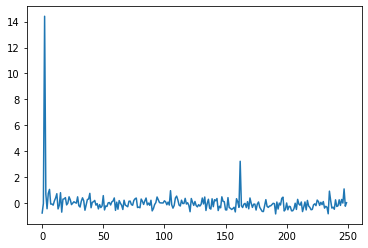

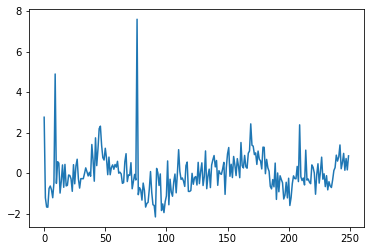

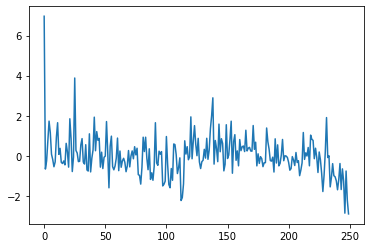

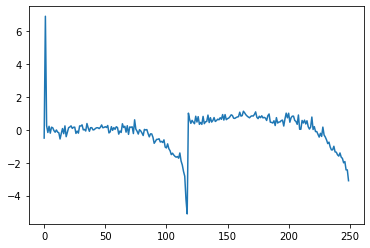

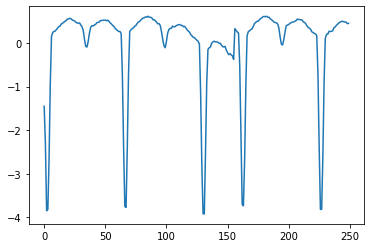

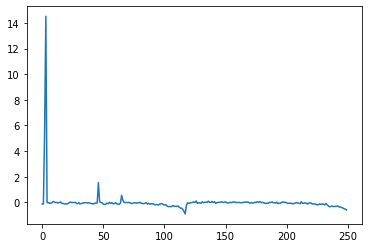

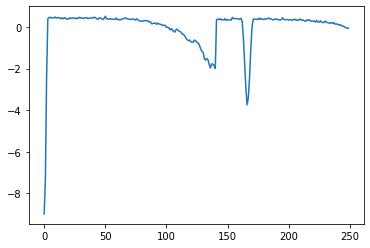

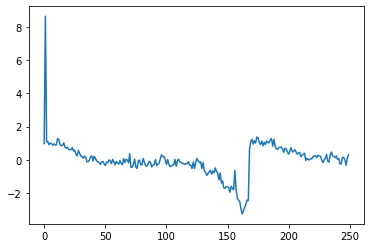

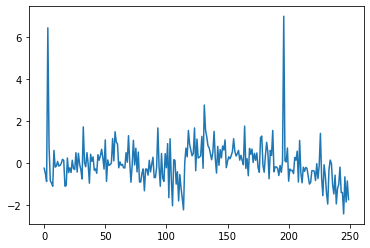

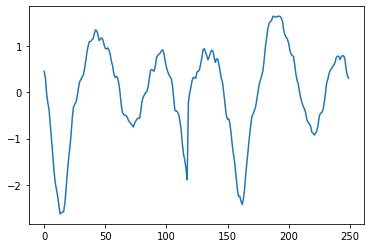

In [224]:
for f in top10:
    d = np.load(f)[1]
    plt.figure()
    sns.lineplot(x=np.arange(len(d)), y=d)
    plt.show()